## LAB 2 - TASK 3 submission. ML 2023-24
FILL UP THIS BOX WITH YOUR DETAILS

**NAME AND NIP**: Luis Calderón Robustillo 896238, Andrés Martínez Silva 904843

## 3. Fine-tunning
Now we going to fine-tune a well known CNN architecture for image classification that has already been trained in ImageNet. We are going to fine-tune this for our own toy-dataset.

## Get data and tensorflow imports ready



In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import backend as K

from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16

import matplotlib.pyplot as plt

In [ ]:
# GET YOUR IMAGES READY

# OPTION A: upload and unzip, untar ... images if necessary (not recommended ... it'll only last one session)
#!tar -xvzf images.tar.gz
# !unzip toy-data.zip
# !ls

# OPTION B: mount your google drive to point the code to find the data in your drive folders
# (instructions here: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA)

from google.colab import drive
drive.mount('/content/drive')
print()

Mounted at /content/drive



In [ ]:
# SOME HELPER FUNCTIONS TO VISUALIZE RESULTS
def vis_history(results_history):
    acc = results_history.history['accuracy']
    val_acc = results_history.history['val_accuracy']

    loss = results_history.history['loss']
    val_loss = results_history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
####### ***** TO-DO-LAB *****  #######
# make sure you config these params to fit what you want/need to LOAD YOUR DATA
# dimensions we will use with our images (they'll be resized if not this shape)
img_width, img_height = 224, 224 # TO MATCH THE SIZES OF THE BASE MODEL WE WANT TO USE, MOBILENET
# MODIFY THE PATH TO POINT TO YOUR DATA! locally here or in your mounted drive
data_dir = '/content/drive/MyDrive/ML/lab2/oxford-iiit-pet/data' # all in one folder and let the system do the split
nb_train_samples = 2000 # UPDATE WITH YOUR NUMBERS!!
nb_validation_samples = 800 # UPDATE WITH YOUR NUMBERS!!
batch_size = 4 #16
num_classes = 5
####### ***** TO-DO-LAB *****  #######

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# for more optimized handling of the data
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 162 files belonging to 5 classes.
Using 130 files for training.
Found 162 files belonging to 5 classes.
Using 32 files for validation.


## Let's do the fine-tunning


Let's load the base model, and modify the final classification layers to adapt to our 5-class toy-dataset. In this example we are fine-tuning MobileNetV2.

There are plenty of base models you could use, this is a pretty good compromise quality vs speed. Many more models in: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
# weights = 'imagenet' is saying we want to upload the model ALREADY TRAINED in Imagenet
# THIS IS ESSENTIAL! otherwise we will just be training the architecture from scratch
IMG_SHAPE = (img_width, img_height) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


# We use the preprocessing method included with the model (for consistency with the pre-trained model we are using)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# apply data augmentation
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=IMG_SHAPE),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)
# let's define our last layer depending on the number of classes we want to classify
prediction_layer = tf.keras.layers.Dense(5)

# Differently from previous example, in this cases it's more convenient
# to build our model using the Keras Model API (https://keras.io/api/models/)
inputs = tf.keras.Input(shape=(img_width, img_height, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
# The base model contains batchnorm layers. It is ESSENTIAL TO SET IT AS inference mode
# SO when we unfreeze the base model for fine-tuning the batchnorm information is not distroyed
# So, we make sure that the base_model is running in inference mode here.
# more details on this in fine-tuning tutorial: https://www.tensorflow.org/guide/keras/transfer_learning
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


print("Let's leave the original model frozen for now ...")
# FREEZE the base model
base_model.trainable = False
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)


Let's leave the original model frozen for now ...
0 input_24 True
1 sequential_11 True
2 tf.math.truediv_11 True
3 tf.math.subtract_11 True
4 mobilenetv2_1.00_224 False
5 global_average_pooling2d_11 True
6 dropout_11 True
7 dense_11 True


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                             

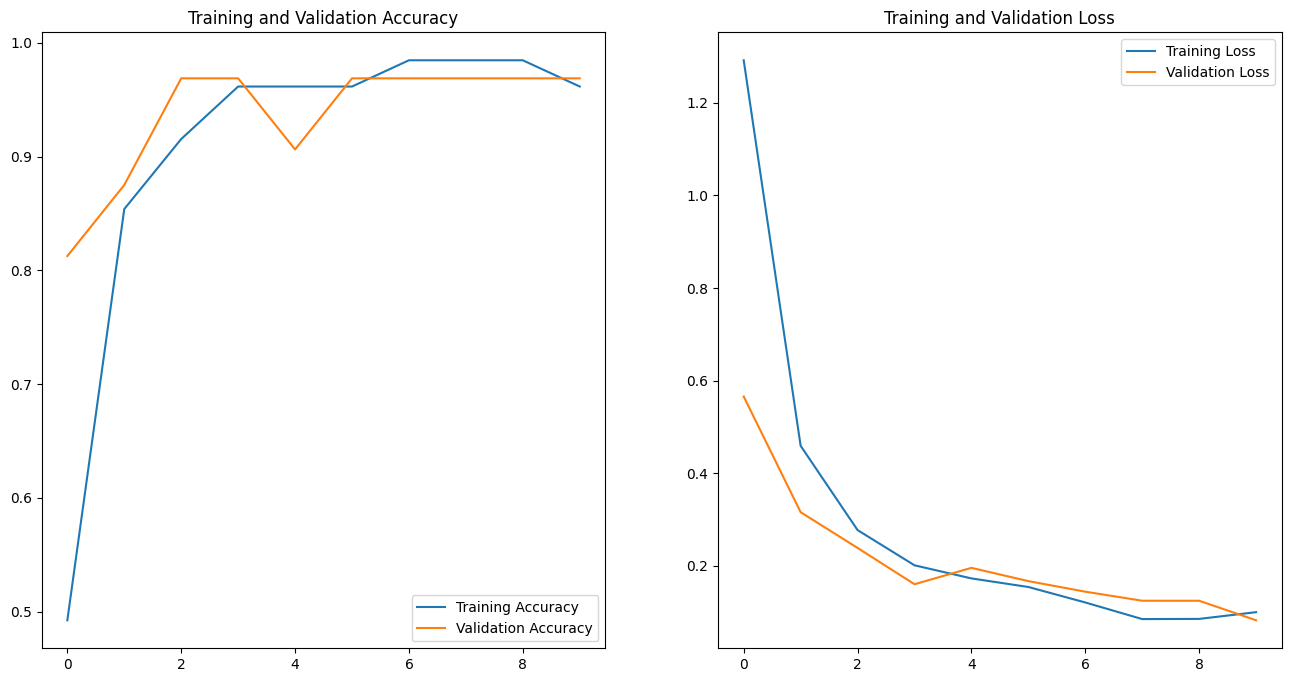

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs = 10 # UPDATE WITH YOUR NUMBERS!!
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

vis_history(history)

In [ ]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all base model layers
print("And now let's enable trainable flag to the BASE MODEL: ")
base_model.trainable = True
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

And now let's enable trainable flag to the BASE MODEL: 
0 input_2 True
1 sequential True
2 tf.math.truediv True
3 tf.math.subtract True
4 mobilenetv2_1.00_224 True
5 global_average_pooling2d True
6 dropout True
7 dense True


As a **final experiment, run a few (ONLY 2 or 3) variations to see HOW/IF your changes influence the results**.
- You can change learning rates (where do you think it makes sense to use smaller? larger?), optimizers, batch size, ...
- INSTEAD of just SAVING THE LAST MODEL. you can add this callback to save "check points" of your model (in this case is set to save only the best one found).
More info: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

You can add plenty of other "utilities" to run during your training process.
More info: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                           

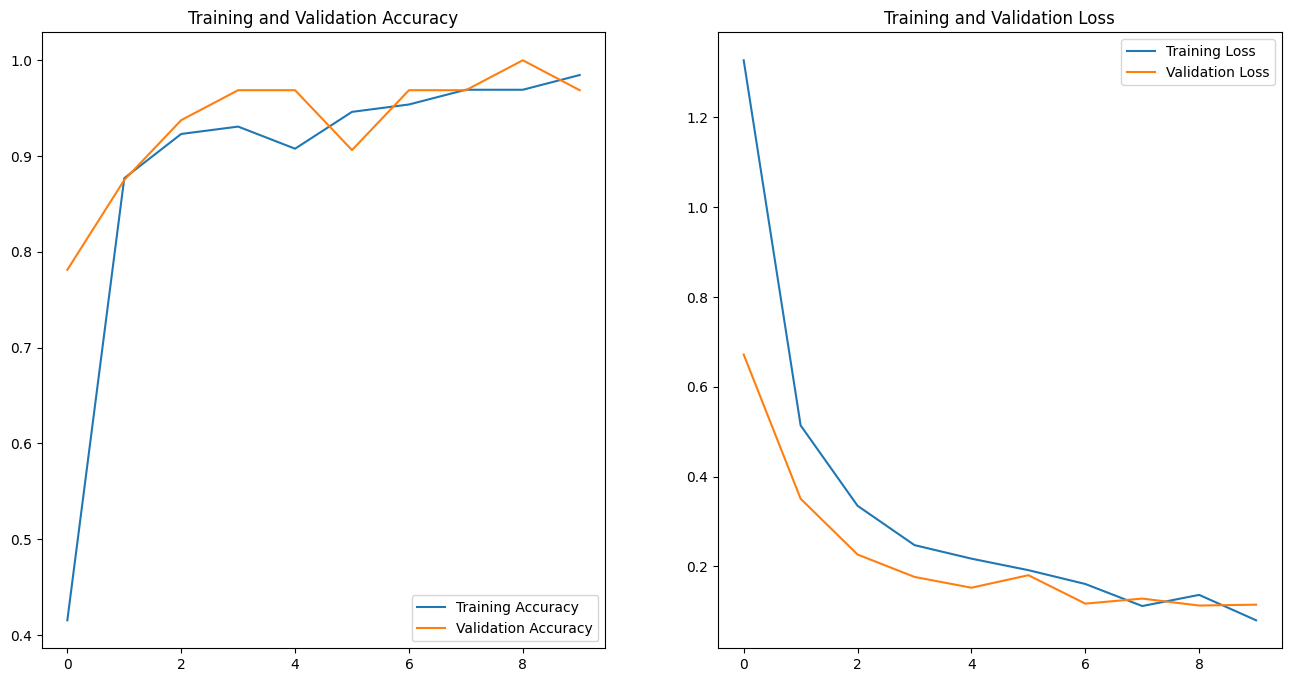

In [ ]:
epochs = 10 # UPDATE WITH YOUR NUMBERS!!

base_learning_rate = 0.0008
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
history2 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
vis_history(history2)

# Save the model
model.save('last_finetuned_model_V1.h5')

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_11 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_11 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 tf.math.subtract_11 (TFOpL  (None, 224, 224, 3)       0         
 ambda)                                                          
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                          

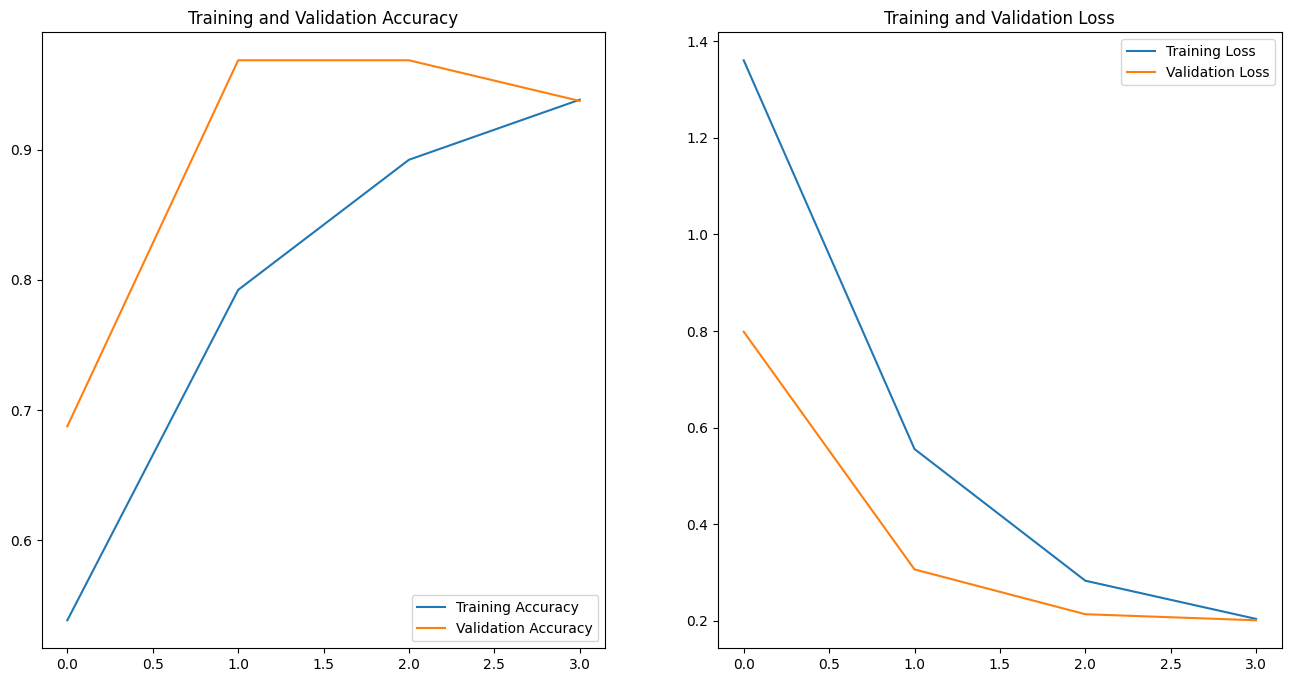

In [ ]:
epochs = 4 # UPDATE WITH YOUR NUMBERS!!

base_learning_rate = 0.0011
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
history2 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
vis_history(history2)

# Save the model
model.save('model_V2.h5')

Epoch 1/5
33/33 [==============================] - 1s 31ms/step - loss: 0.2281 - accuracy: 0.9000 - val_loss: 0.1748 - val_accuracy: 0.9375
Epoch 2/5
33/33 [==============================] - 1s 25ms/step - loss: 0.1916 - accuracy: 0.9308 - val_loss: 0.1465 - val_accuracy: 0.9375
Epoch 3/5
33/33 [==============================] - 1s 23ms/step - loss: 0.1331 - accuracy: 0.9615 - val_loss: 0.1475 - val_accuracy: 0.9688
Epoch 4/5
33/33 [==============================] - 0s 14ms/step - loss: 0.1288 - accuracy: 0.9615 - val_loss: 0.1401 - val_accuracy: 0.9375
Epoch 5/5
33/33 [==============================] - 0s 14ms/step - loss: 0.1180 - accuracy: 0.9615 - val_loss: 0.1344 - val_accuracy: 0.9375


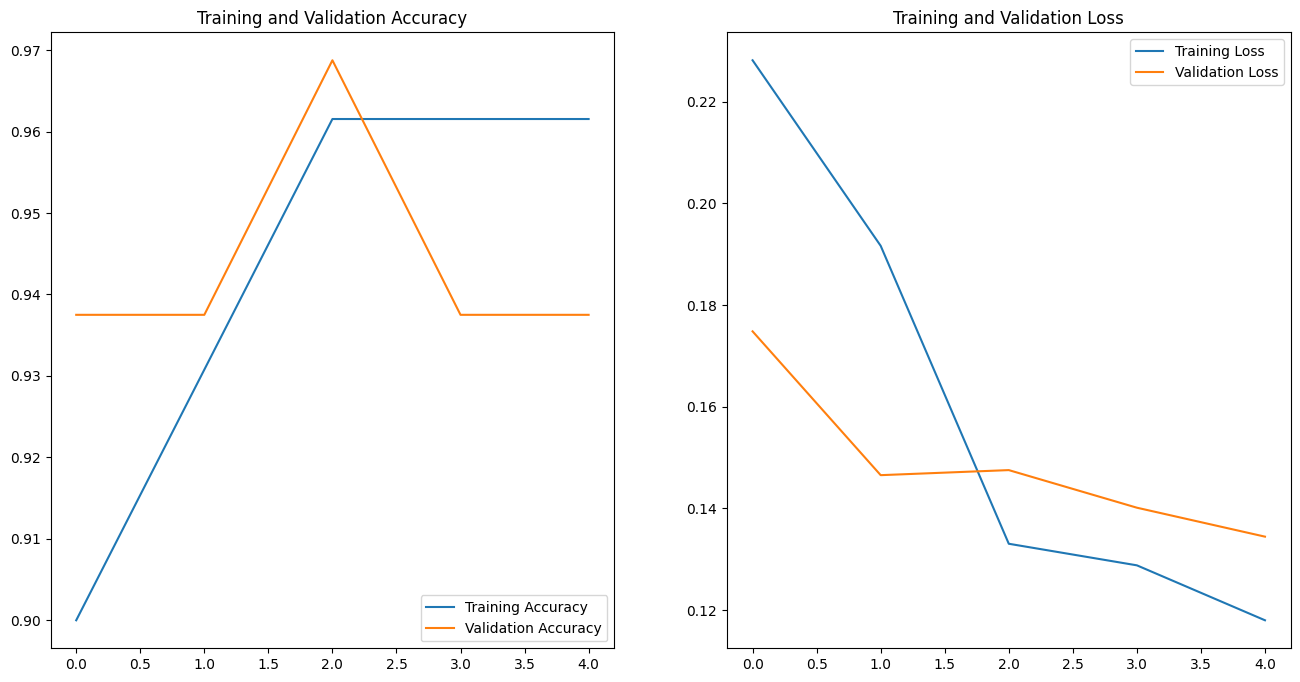

In [ ]:
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.

epochs = 5 # UPDATE WITH YOUR NUMBERS!!

base_learning_rate = 0.0006

history3 = model.fit(
 train_ds,
 validation_data=val_ds,
 epochs=epochs,
 callbacks=[model_checkpoint_callback]
)

vis_history(history3)

# Save the model
model.save('last_finetuned_model_V1.h5')

### **QUESTION 1**. Answer True/False and explain why you think so.

1. After reading the explanations in this notebook, I think when fine-tuning and existing model, we usually start with its layers frozen, but later we should un-freeze *ALL* layers always.

2.   It is essential to make sure when loading the base model, its parameter *weights* are initialized to the pre-trained weigths we want, usually imagenet.

*ANSWER* 1:

FALSE. We start by freezing layers during fine-tuning, but it's not necessary to unfreeze ALL layers later. Fine-tuning involves selectively unfreezing specific layers based on task requirements.

TRUE. It's crucial to ensure that when loading a base model, its weights are initialized to the desired pre-trained weights, such as from ImageNet. This provides a solid starting point for transfer learning.

### **QUESTION 2**.
Discuss the results you have obtained with your toy-data after running the different steps of the fine tunning process and the variations you have incorporated.

* How does it compare to the previous tasks in this Lab 3? What are advantages/disadvantages you find within each option? (max 10 lines).





ANSWER 2:

Models:

- epochs 10 LR 0.001 -> This model gives very decent results, although perhaps it seems to reach very quickly good accuracy and therefore we may be causing some overfitting in the last epochs.
(loss: 0.0999 - accuracy: 0.9615 - val_loss: 0.0824 - val_accuracy: 0.9688)

- epochs 10 LR 0.0008 -> For this model we lower the LR a little to avoid the previous problem, resulting in a slightly better outcome with no apparent overfitting.
(loss: 0.0797 - accuracy: 0.9846 - val_loss: 0.1145 - val_accuracy: 0.9688)

- epochs 4 LR 0.0011 - epochs 5 LR 0.00006 -> As a final approach we tried to create a first phase in which we only have 4 epochs with higher LR to avoid local minima. From that result we run another 5 epochs with much lower LR to try to reach better values, however we didn't manage to improve the results.
(loss: 0.1180 - accuracy: 0.9615 - val_loss: 0.1344 - val_accuracy: 0.9375)

Finally, from these experiments we would choose the second model (saved as 'last_finetuned_model_V1.h5'). However, it seems important to state that overall, these results are much better than those obtained with all of the models created in the previous task. Even with data augmentation, the models in task 2 don't reach a very accurate solution because they are very simple models trained on a very reduced dataset. On the other hand, this a very good example of how powerful transfer learning can be, especially with a careful approach to fine tuning.